#Segundo intento#



*   Solo con los datos de Madrid de Idealista2018
*   Madrid_Sale.csv y Madrid_Polygons.rda bajados de https://github.com/paezha/idealista18/tree/e2cfe3f621e1c37f226ce956f61b7306c42d5721/data


*   archivo Madrid_Polygons.rda transformado en csv con Notebook en R Script R rda a csv.ipyn https://colab.research.google.com/drive/1I06zwKUreseL1p87dHq0TzMheUHiEmVc


*   Exploración de datos (EDA) copiado de https://github.com/enricobonii/Idealista-Project/blob/main/IdealistaProject%20v4.ipynb
*Agregar la Columna neighbourhood a df_Madrid: de la latitud y longitud de cada casa se busca el barrio al que corresponde en Madrid_Polygons.csv


* a Madrid_Polygons se le añade la columna mean_UNITPRICE para utilizarla posteriormente para calcular precios de casas en 2024.

* Se intenta bajar la geometria de la M30, para calcular la distancia de los pisos a esta, y para definir si están dentro de la M30 o fuera. Como no funciona porque los datos de la M30 incluyen las carreteras radiales, y no se cierra, en las próximas versiones se desechará la M30

* Se calcula el número de estaciones de Metro que hay en un radio de 500m alrededor de cada casa, y se guarda en la nueva columna metro_within_500m

* finalmente, se guarda el dataframe como gdf_Madrid_with_metro_count.csv en el Google drive asi como Madrid_Polygons_with_mean_unitprice.csv

* lo siguiente, Multivariate Analysis etc. copiado de https://github.com/enricobonii/Idealista-Project/blob/main/IdealistaProject%20v4.ipynb no se ha tocado de momento





In [1]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

# Ruta al archivo CSV en Google Drive
file_path = '/content/drive/My Drive/Idealista_2024/datos_2018/'

Mounted at /content/drive


In [2]:
from getpass import getpass
import os

# Solicita el token personal de GitHub
token = getpass('GitHub Token: ')

# Define la URL del repositorio y la ruta de clonación
repo_url = "https://github.com/edouardor/Idealista_2024.git"
destino = "/content/drive/MyDrive/Idealista_2024"

# Clona el repositorio en la carpeta de Google Drive
os.system(f'git clone https://{token}@github.com/edouardor/Idealista_2024.git {destino}')


GitHub Token: ··········


32768

In [3]:
%cd /content/drive/MyDrive/Idealista_2024

/content/drive/MyDrive/Idealista_2024


In [4]:
!ls -a


datos_2018  datos_2024	.git  .ipynb_checkpoints  Notebooks  README.md


In [ ]:
!git config --global user.email "edouardo@hotmail.es"
!git config --global user.name "edouardor"

In [ ]:
# Agregar los archivos modificados
!git add .

# Hacer un commit
!git commit -m "Actualización desde Google Colab"

# Hacer push de los cambios
!git push


[main 8ccb0f9] Actualización desde Google Colab
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Notebooks/Idealista Madrid github.ipynb (71%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.46 MiB | 4.48 MiB/s, done.
Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/edouardor/Idealista_2024.git
   0741232..8ccb0f9  main -> main


**Para ver las diferencias con el notebook anterior:**

*descomentar las lineas siguientes*

In [ ]:
#!pip install nbdime
#!nbdiff Notebooks/"Idealista Madrid github.ipynb"


In [ ]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import radians, cos, sin, asin, sqrt
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_columns', None)

## Initializing Datasets

###Solo Madrid


In [ ]:

df= pd.read_csv(file_path+'gdf_Madrid_with_metro_count.csv')


In [ ]:
gdf = pd.read_csv(file_path+'Madrid_Polygons_with_mean_unitprice.csv')

*para poner luego los clusters definidos para cada barrio*

In [ ]:
df.head(3)

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m
0,A2624736749193113090,4,166000,1844.444444,HOME,SALE,90,2,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1.0,1986,10,32,5.0,0,0,1,7.953755,0.402011,6.504196,-3.611866,40.431013,Madrid,HOME,SALE,Hellín,2
1,A8841356095019025740,3,133000,1727.272727,HOME,SALE,77,3,1,1,1,1,3,0,0,1,1,0,0,0,0,0,0,0,0,0,3.0,1.0,1960,4,80,7.0,0,0,1,7.443821,0.480740,5.961369,-3.618239,40.431754,Madrid,HOME,SALE,Hellín,1
2,A6716251930495709236,3,98000,1719.298246,HOME,SALE,57,2,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1960,4,9,7.0,0,0,1,7.473113,0.287270,6.039694,-3.617411,40.430101,Madrid,HOME,SALE,Hellín,1


## Exploratory Data Analysis

In [ ]:
print(df.dtypes)

ASSETID                     object
PERIOD                       int64
PRICE                        int64
UNITPRICE                  float64
ADTYPOLOGYID                object
ADOPERATIONID               object
CONSTRUCTEDAREA              int64
ROOMNUMBER                   int64
BATHNUMBER                   int64
HASTERRACE                   int64
HASLIFT                      int64
HASAIRCONDITIONING           int64
AMENITYID                    int64
HASPARKINGSPACE              int64
HASNORTHORIENTATION          int64
HASSOUTHORIENTATION          int64
HASEASTORIENTATION           int64
HASWESTORIENTATION           int64
HASBOXROOM                   int64
HASWARDROBE                  int64
HASSWIMMINGPOOL              int64
HASDOORMAN                   int64
HASGARDEN                    int64
ISDUPLEX                     int64
ISSTUDIO                     int64
ISINTOPFLOOR                 int64
FLOORCLEAN                 float64
FLATLOCATIONID             float64
CADCONSTRUCTIONYEAR 

From here we can observe that the formatted variable types make sense with the expected and are homogeneous among the different datasets.

In [ ]:
df.describe(include='all')

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m
count,75740,75740.000000,7.574000e+04,75740.000000,75740,75740,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740.000000,75740,75740,75740,75740,75740.000000
unique,75740,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,135,NaN
top,A2624736749193113090,NaN,NaN,NaN,HOME,SALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Madrid,HOME,SALE,Lavapiés-Embajadores,NaN
freq,1,NaN,NaN,NaN,75740,75740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75740,75740,75740,2947,NaN
mean,NaN,2.784500,3.885028e+05,3632.521702,NaN,NaN,100.217586,2.570148,1.570240,0.351149,0.689213,0.439041,2.924835,0.216794,0.104383,0.231344,0.196343,0.142831,0.249908,0.563982,0.141907,0.247320,0.176657,0.025297,0.027079,0.021495,2.714840,0.871283,1965.446409,6.360536,38.695801,4.870399,0.031780,0.186903,0.781318,4.474552,0.469338,2.675121,-3.686323,40.420673,NaN,NaN,NaN,NaN,1.457182
std,NaN,1.209515,4.124885e+05,1708.417808,NaN,NaN,66.433670,1.246913,0.835428,0.477332,0.462819,0.496273,0.313232,0.412064,0.305759,0.421695,0.397233,0.349902,0.432962,0.495893,0.348957,0.431457,0.381381,0.157027,0.162316,0.145027,2.211571,0.334888,28.916426,2.843000,53.290795,1.460220,0.175414,0.389836,0.413355,2.669527,0.593230,2.199341,0.038916,0.033458,NaN,NaN,NaN,NaN,1.314439
min,NaN,1.000000,2.100000e+04,805.309734,NaN,NaN,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,1623.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.007647,0.001416,0.001435,-3.832534,40.328682,NaN,NaN,NaN,NaN,0.000000
25%,NaN,2.000000,1.570000e+05,2200.000000,NaN,NaN,62.000000,2.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1955.000000,5.000000,12.000000,4.000000,0.000000,0.000000,1.000000,2.401815,0.212906,1.040583,-3.708313,40.396519,NaN,NaN,NaN,NaN,0.000000
50%,NaN,3.000000,2.560000e+05,3440.000000,NaN,NaN,82.000000,3.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1967.000000,6.000000,21.000000,5.000000,0.000000,0.000000,1.000000,4.112561,0.329996,1.961970,-3.694002,40.423025,NaN,NaN,NaN,NaN,1.000000
75%,NaN,4.000000,4.560000e+05,4719.558389,NaN,NaN,115.000000,3.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1983.000000,8.000000,39.000000,6.000000,0.000000,0.000

In [ ]:
# prompt: drop observertions where df[df['ROOMNUMBER']>20]

df = df[df['ROOMNUMBER'] <= 20]

## Multivariate Analysis

**Voy a cambiar la LATITUD y LONGITUD por la distancia en km a Nuevos Ministerios (AZCA), medida como si fuera una cuadrícula**

mido la distancia a un punto con la misma latitud que AZCA, y a otro con la misma longitud


*The coordinates are converted from latitude and longitude to northing and easting in meters, and then rescaled and centered using the corresponding city’s Central Business District as a false origin. These transformations have no impact on the analysis, and rescaling and centering of the coordinates is necessary for the correct implementation of the interactive basis functions in decision trees (see Antonio Paez et al. 2019, 188–89). https://github.com/paezha/Machine-learning-for-market-segmentation*

In [ ]:
# Definir la función de Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radio de la Tierra en km

    # Convertir las coordenadas de grados a radianes
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    # Aplicar la fórmula de Haversine
    a = np.sin(delta_phi / 2.0) ** 2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


# Coordenadas del punto de referencia
,
ref_lat = 40.446195
ref_lon = -3.691269

# Calcular las distancias
# Crear nuevas columnas 'DISTANCIA_LATITUD' y 'DISTANCIA_LONGITUD'
df['DISTANCIA_LATITUD'] = haversine(df['LATITUDE'], ref_lon, ref_lat, ref_lon)
df['DISTANCIA_LONGITUD'] = haversine(ref_lat, df['LONGITUDE'], ref_lat, ref_lon)

# Mostrar el DataFrame resultante
print(df.head())


                ASSETID  PERIOD   PRICE    UNITPRICE ADTYPOLOGYID  \
0  A2624736749193113090       4  166000  1844.444444         HOME   
1  A8841356095019025740       3  133000  1727.272727         HOME   
2  A6716251930495709236       3   98000  1719.298246         HOME   
3  A1897858214850462442       4  125000  2016.129032         HOME   
4   A602619672115044517       3  111000  1947.368421         HOME   

  ADOPERATIONID  CONSTRUCTEDAREA  ROOMNUMBER  BATHNUMBER  HASTERRACE  HASLIFT  \
0          SALE               90           2           1           0        1   
1          SALE               77           3           1           1        1   
2          SALE               57           2           1           0        0   
3          SALE               62           3           1           0        0   
4          SALE               57           2           1           0        0   

   HASAIRCONDITIONING  AMENITYID  HASPARKINGSPACE  HASNORTHORIENTATION  \
0                   0   

<ipython-input-16-6d7941c78a43>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DISTANCIA_LATITUD'] = haversine(df['LATITUDE'], ref_lon, ref_lat, ref_lon)
<ipython-input-16-6d7941c78a43>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DISTANCIA_LONGITUD'] = haversine(ref_lat, df['LONGITUDE'], ref_lat, ref_lon)


In [ ]:
# Correlation analysis
'''
#CHANGE THE COLUMN CADCONSTRUCTIONYEAR datatype from int to year
df_Barcelona['CADCONSTRUCTIONYEAR'] = pd.to_datetime(df_Barcelona['CADCONSTRUCTIONYEAR'], format='%Y')
df_Barcelona['CADCONSTRUCTIONYEAR'] = df_Barcelona['CADCONSTRUCTIONYEAR'].dt.year

#Add a column CadBuildingAge in barcelona dataset where age is current year - cadconstructionyear
barcelona['CADBUILDINGAGE'] = dt.datetime.now().year - barcelona['CADCONSTRUCTIONYEAR']
barcelona = barcelona.drop(columns=['CADCONSTRUCTIONYEAR'])
'''

"\n#CHANGE THE COLUMN CADCONSTRUCTIONYEAR datatype from int to year\ndf_Barcelona['CADCONSTRUCTIONYEAR'] = pd.to_datetime(df_Barcelona['CADCONSTRUCTIONYEAR'], format='%Y')\ndf_Barcelona['CADCONSTRUCTIONYEAR'] = df_Barcelona['CADCONSTRUCTIONYEAR'].dt.year\n\n#Add a column CadBuildingAge in barcelona dataset where age is current year - cadconstructionyear\nbarcelona['CADBUILDINGAGE'] = dt.datetime.now().year - barcelona['CADCONSTRUCTIONYEAR']\nbarcelona = barcelona.drop(columns=['CADCONSTRUCTIONYEAR'])\n"

As per the above table, we can see that the columns CONSTRUCTEDAREA, BATHNUMBER, ROOMNUMBER, HASPARKINGSPACE, DISTANCE_TO_DIAGONAL, CADASTRALQUALITYID, ISPARKINGSPACEINCLUDEDINPRICE, HASDOORMAN, HASLIFT, HASTERRACE are some of the columns that have a higher correlation with the PRICE of the asset listed.


<Figure size 1600x1100 with 0 Axes>

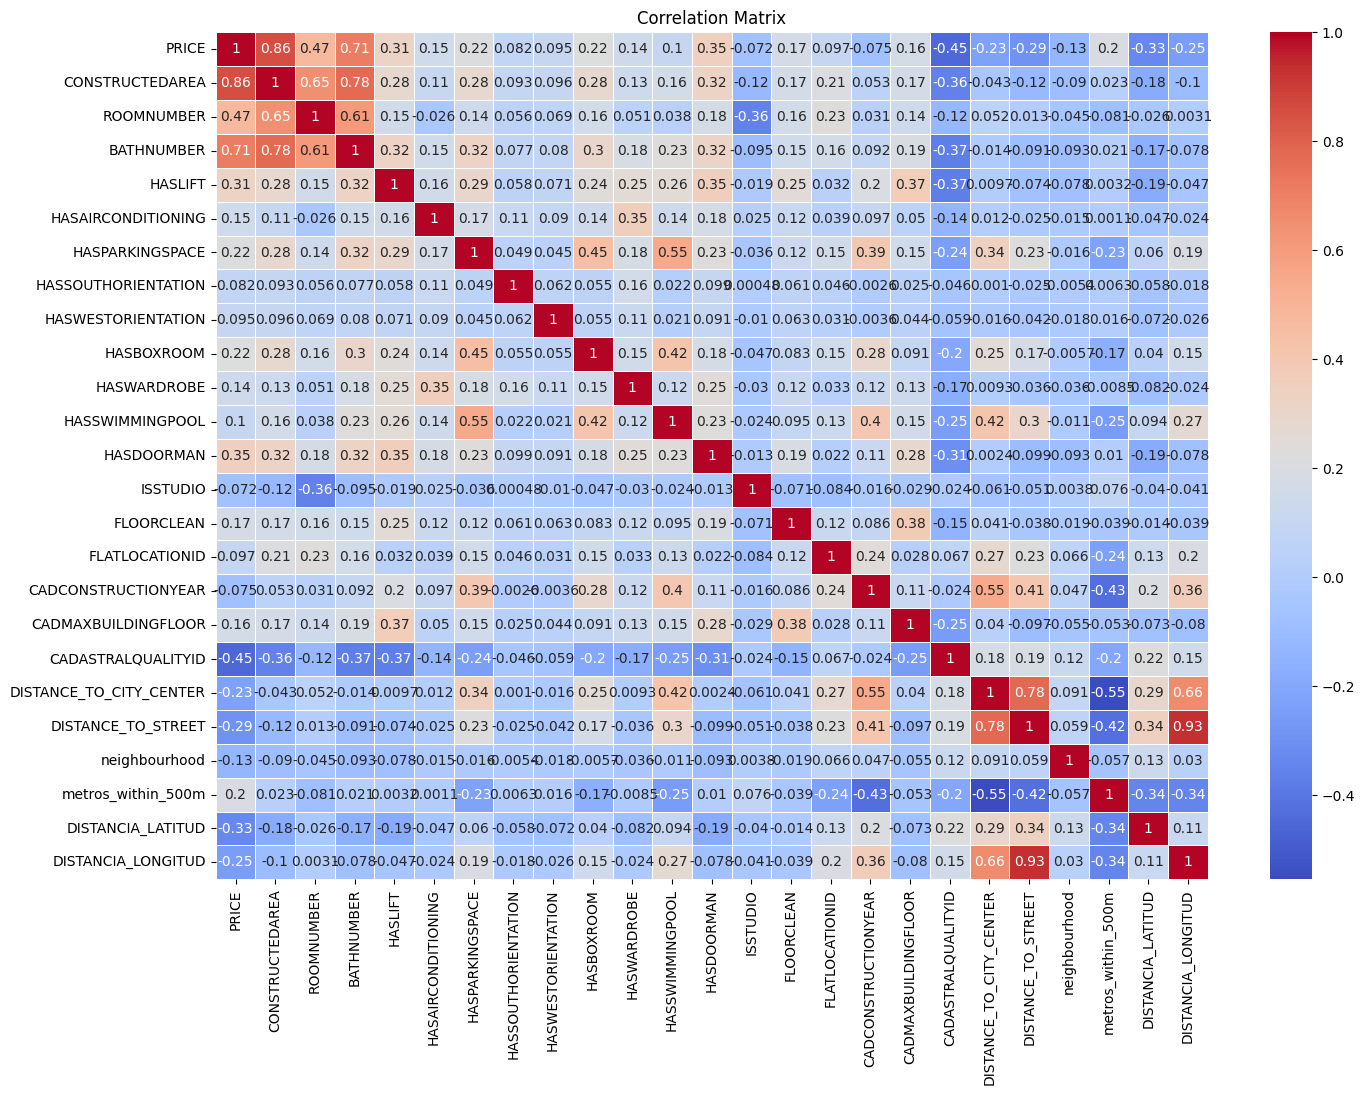

In [ ]:
madrid = df.drop(columns=['ADOPERATIONID', 'UNITPRICE', 'LATITUDE', 'LONGITUDE','AMENITYID','ASSETID','ADTYPOLOGY','CITYNAME','ADOPERATION','ADTYPOLOGYID'])

# Encode the location names (label encoding)
madrid['neighbourhood'] = df['neighbourhood'].astype('category').cat.codes

plt.figure(figsize=(16, 11))
correlation_madrid = madrid.corr()

# Identify columns where absolute correlation with 'PRICE' is less than 0.07
low_corr_columns = correlation_madrid['PRICE'][abs(correlation_madrid['PRICE']) < 0.07].index

# Drop the identified columns from the DataFrame
madrid_filtered = madrid.drop(columns=low_corr_columns)

plt.figure(figsize=(16, 11))
correlation_madrid = madrid_filtered.corr()
sns.heatmap(correlation_madrid, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
print(madrid.dtypes)

PERIOD                       int64
PRICE                        int64
CONSTRUCTEDAREA              int64
ROOMNUMBER                   int64
BATHNUMBER                   int64
HASTERRACE                   int64
HASLIFT                      int64
HASAIRCONDITIONING           int64
HASPARKINGSPACE              int64
HASNORTHORIENTATION          int64
HASSOUTHORIENTATION          int64
HASEASTORIENTATION           int64
HASWESTORIENTATION           int64
HASBOXROOM                   int64
HASWARDROBE                  int64
HASSWIMMINGPOOL              int64
HASDOORMAN                   int64
HASGARDEN                    int64
ISDUPLEX                     int64
ISSTUDIO                     int64
ISINTOPFLOOR                 int64
FLOORCLEAN                 float64
FLATLOCATIONID             float64
CADCONSTRUCTIONYEAR          int64
CADMAXBUILDINGFLOOR          int64
CADDWELLINGCOUNT             int64
CADASTRALQUALITYID         float64
BUILTTYPEID_1                int64
BUILTTYPEID_2       

In [ ]:
# print list of columns from correlation matrix in decreasing order of correlation with Price
correlation_madrid['PRICE'].sort_values(ascending=False)

,PRICE
PRICE,1.000000
CONSTRUCTEDAREA,0.856451
BATHNUMBER,0.712037
ROOMNUMBER,0.471946
HASDOORMAN,0.345088
HASLIFT,0.314891
HASBOXROOM,0.221086
HASPARKINGSPACE,0.215118
metros_within_500m,0.196744
FLOORCLEAN,0.173261


As per the above table, in Madrid,, we can see that the columns CONSTRUCTEDAREA, BATHNUMBER, ROOMNUMBER, HASDOORMAN, HASLIFT, HASPARKINGSPACE, metro_within_500 m, FloorClean are some of the columns that have a higher correlation with the PRICE of the asset listed.

**Analysing the pricing of assets based on location**

<ipython-input-21-91ba5e97af2c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='UNITPRICE', y='neighbourhood', data=average_prices, palette='viridis')


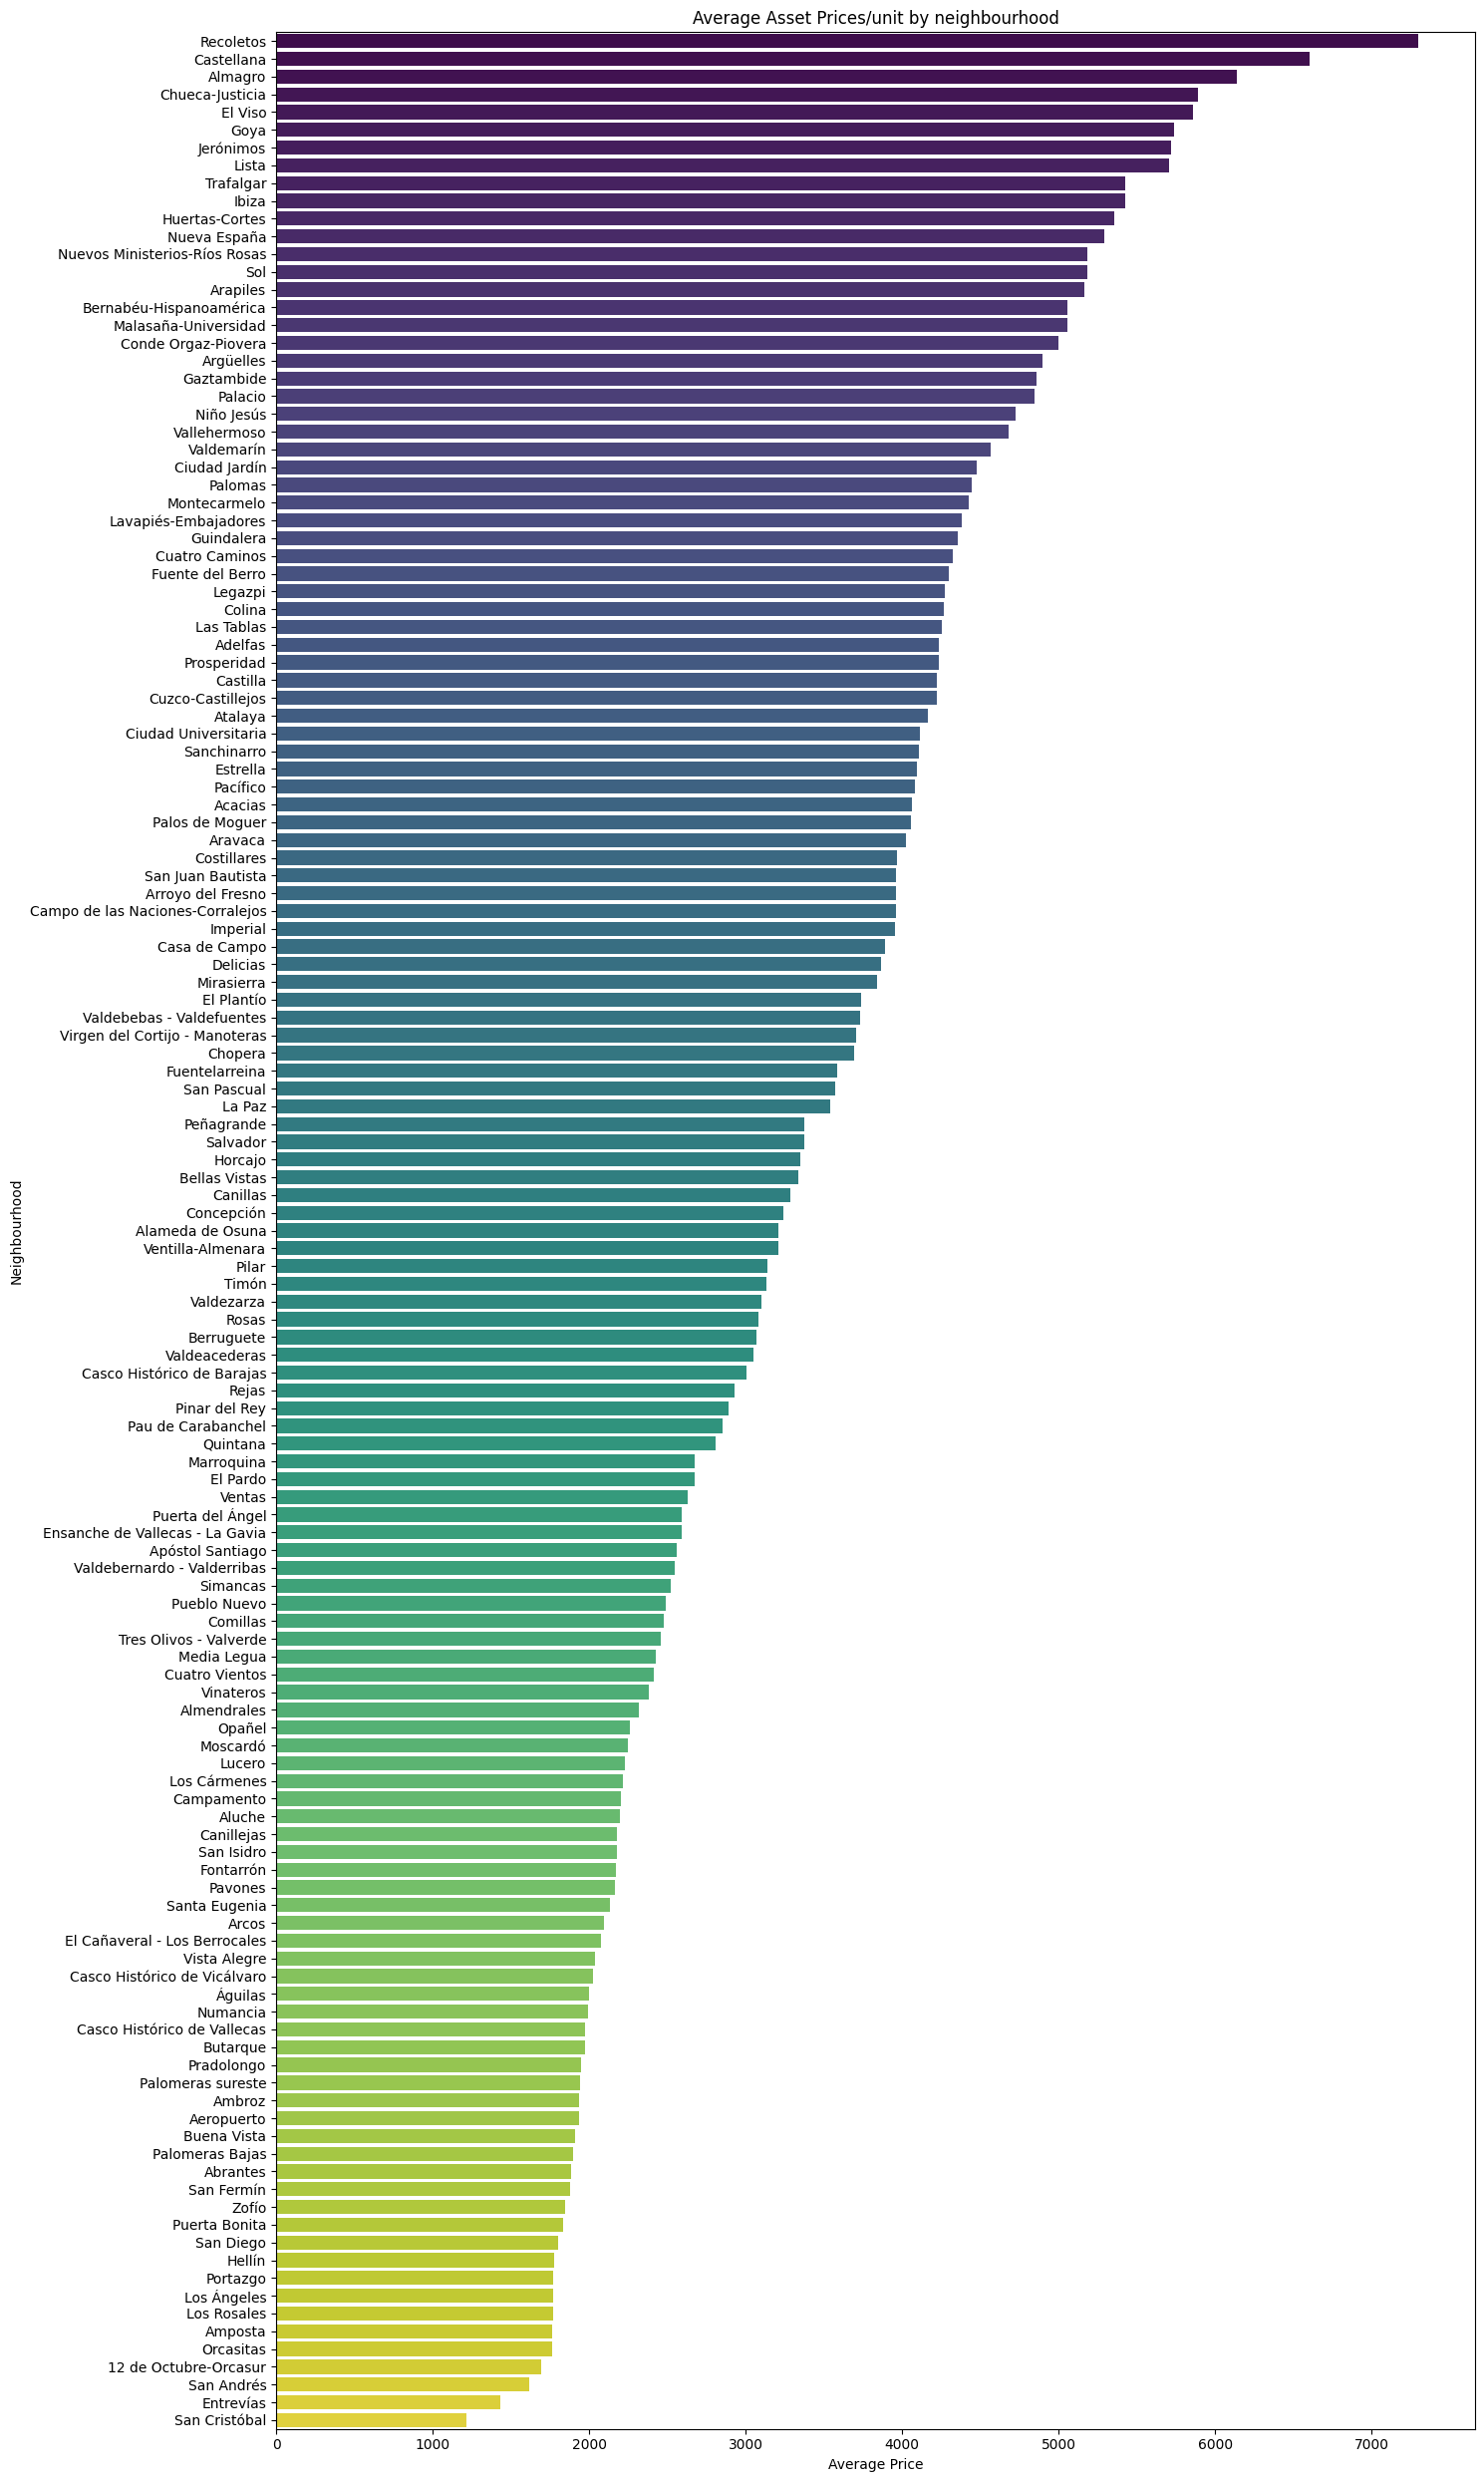

In [ ]:
madrid_unit = df.copy()
# Encode the location names (label encoding)
madrid_unit['neighbourhood'] = df['neighbourhood'].astype('category').cat.codes

# Calculate average price by neighbourhood
average_prices = madrid_unit.groupby('neighbourhood')['UNITPRICE'].mean().reset_index()

#Map the neighbourhoods to their respective names
neighbourhood_map = dict(zip(madrid_unit['neighbourhood'], df['neighbourhood']))
average_prices['neighbourhood'] = average_prices['neighbourhood'].map(neighbourhood_map)

# Sort the neighbourhoods by average price in descending order
average_prices = average_prices.sort_values(by='UNITPRICE', ascending=False)

# Plot the average prices by neighbourhood
plt.figure(figsize=(15, 25))
sns.barplot(x='UNITPRICE', y='neighbourhood', data=average_prices, palette='viridis')

plt.title('Average Asset Prices/unit by neighbourhood')
plt.ylabel('Neighbourhood')
plt.xlabel('Average Price')
plt.tight_layout()

# Show the plot
plt.show()

As we see above, in Madrid, the neighbourhoods with the highest average asset unit prices (price per meter square) are: Recoletos, Castellana, Almagro, and Chueca. So the asset to be listed in/around these areas can have a high asking price (around 6500/m2). Places such as San Andres, Entrevias or San Cristobal have the lowest average asset prices. So the asset to be listed in/around these areas can have a low asking price (around 1300/m2).

In [ ]:
madrid_unit['neighbourhood'].value_counts()

,count
neighbourhood,
67,2947
74,2094
57,1636
58,1483
100,1395
...,...
4,35
60,33
48,32


In [ ]:
df_Madrid = df.copy()

**Importamos las Librerías Necesarias**

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns

**calculamos el precio medio del metro cuadrado por barrio:**

In [ ]:
# Agrupar por barrio y calcular el precio medio del m²
precio_medio_barrio = df_Madrid.groupby('neighbourhood')['UNITPRICE'].mean().reset_index()

# Renombrar la columna para mayor claridad
precio_medio_barrio.rename(columns={'UNITPRICE': 'Precio_medio_m2'}, inplace=True)

print(precio_medio_barrio.head())


           neighbourhood  Precio_medio_m2
0  12 de Octubre-Orcasur      1691.738616
1               Abrantes      1883.393662
2                Acacias      4060.447024
3                Adelfas      4234.270086
4             Aeropuerto      1933.102614


**Determinamos el Número Óptimo de Grupos**

*Antes de realizar la agrupación, es útil determinar cuántos grupos (clusters) son apropiados. Una técnica común para esto es el método del codo.*

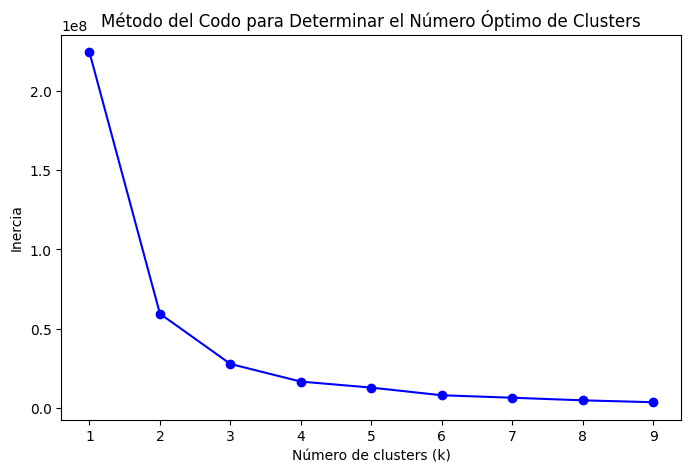

In [ ]:
# Lista para almacenar la inercia
inercia = []
K = range(1, 10)

for k in K:
    modelo = KMeans(n_clusters=k, random_state=42)
    modelo.fit(precio_medio_barrio[['Precio_medio_m2']])
    inercia.append(modelo.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, inercia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.show()


*Buscamos un "codo" en la gráfica donde la inercia comienza a disminuir de manera menos pronunciada. Aquí k=6*

**Aplicar K-Means para Agrupar los Barrios**

In [ ]:
# Definir el número de clusters
k_optimo = 6

# Inicializar y ajustar el modelo
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
precio_medio_barrio['Cluster'] = kmeans.fit_predict(precio_medio_barrio[['Precio_medio_m2']])

# Opcional: Añadir los centroides
centroides = kmeans.cluster_centers_


             neighbourhood  Precio_medio_m2  Cluster
109          San Cristóbal      1216.039306        3
51               Entrevías      1435.370349        3
108             San Andrés      1614.537321        3
0    12 de Octubre-Orcasur      1691.738616        3
85               Orcasitas      1760.497473        3
..                     ...              ...      ...
49                 El Viso      5857.527431        2
34         Chueca-Justicia      5886.168649        2
6                  Almagro      6135.451127        2
31              Castellana      6602.187555        2
104              Recoletos      7294.535936        2

[135 rows x 3 columns]


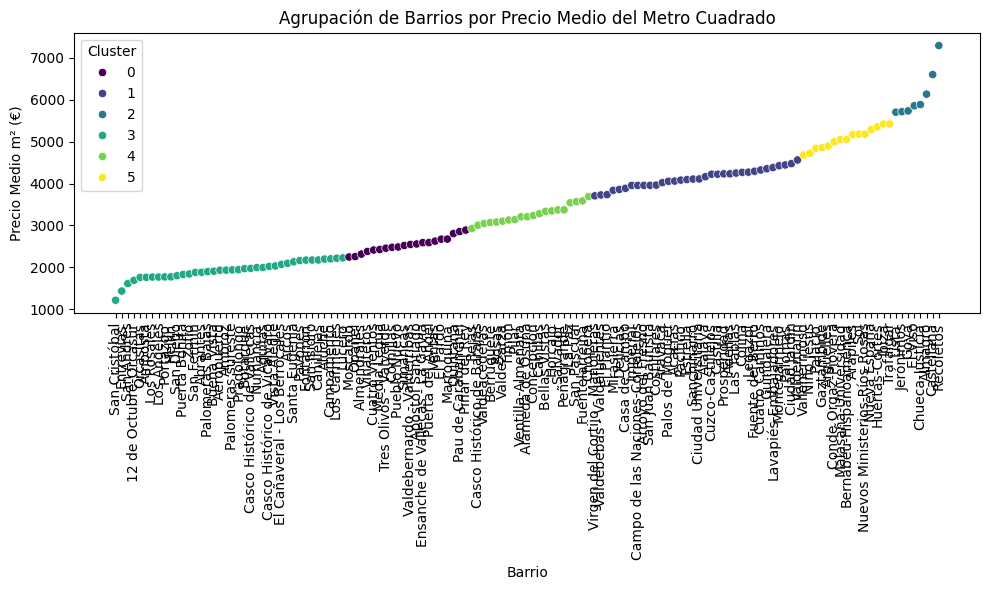

In [ ]:
# Ordenar los barrios por precio medio y cluster
precio_medio_barrio.sort_values('Precio_medio_m2', inplace=True)

print(precio_medio_barrio)

# Visualización con Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=precio_medio_barrio, x='neighbourhood', y='Precio_medio_m2', hue='Cluster', palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('Precio Medio m² (€)')
plt.title('Agrupación de Barrios por Precio Medio del Metro Cuadrado')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


**Nos Aseguramos la Consistencia de los Nombres de Barrios entre los ficheros**

In [ ]:
# Convertir a mayúsculas y eliminar espacios adicionales para asegurar coincidencias
precio_medio_barrio['neighbourhood'] = precio_medio_barrio['neighbourhood'].str.upper().str.strip()
gdf['LOCATIONNAME'] = gdf['LOCATIONNAME'].str.upper().str.strip()

# Opcional: Verificar barrios que no coinciden
barrios_df = set(precio_medio_barrio['neighbourhood'])
barrios_gdf = set(gdf['LOCATIONNAME'])
barrios_faltantes = barrios_df - barrios_gdf
if barrios_faltantes:
    print("Barrios en precio_medio_barrio que no están en gdf:", barrios_faltantes)

barrios_faltantes_gdf = barrios_gdf - barrios_df
if barrios_faltantes_gdf:
    print("Barrios en gdf que no están en precio_medio_barrio:", barrios_faltantes_gdf)


In [ ]:
gdf.head()

,LOCATIONID,LOCATIONNAME,ZONELEVELID,WKT_geometry,mean_UNITPRICE
0,0-EU-ES-28-07-001-079-16-002,CONDE ORGAZ-PIOVERA,8,"MULTIPOLYGON (((-3.63014 40.44939, -3.62633 40...",4997.529056
1,0-EU-ES-28-07-001-079-16-004,PINAR DEL REY,8,"MULTIPOLYGON (((-3.655102 40.46681, -3.654251 ...",2890.201338
2,0-EU-ES-28-07-001-079-21-004,TIMÓN,8,"MULTIPOLYGON (((-3.581744 40.47973, -3.60157 4...",3131.335558
3,0-EU-ES-28-07-001-079-01-001,PALACIO,8,"MULTIPOLYGON (((-3.72044 40.42028, -3.72097 40...",4841.978005
4,0-EU-ES-28-07-001-079-01-003,HUERTAS-CORTES,8,"MULTIPOLYGON (((-3.696488 40.41881, -3.699685 ...",5353.127293


In [ ]:
import geopandas as gpd
from shapely import wkt

# Asegúrate de que 'WKT_geometry' está en formato string
gdf['WKT_geometry'] = gdf['WKT_geometry'].astype(str)

# Convertir la columna WKT a objetos geométricos
gdf['geometry'] = gdf['WKT_geometry'].apply(wkt.loads)


# Asegurarse de que 'gdf' es un GeoDataFrame
# Si no lo es, convertirlo
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')  # Ajusta según corresponda

# Fusionar los DataFrames
gdf = gdf.merge(precio_medio_barrio[['neighbourhood', 'Cluster']], how='left',
                left_on='LOCATIONNAME', right_on='neighbourhood')

# Opcional: Verificar si hay valores NaN en 'Cluster' después de la fusión
barrios_sin_cluster = gdf[gdf['Cluster'].isna()]['LOCATIONNAME'].unique()
if len(barrios_sin_cluster) > 0:
    print("Barrios sin asignar a un cluster:", barrios_sin_cluster)

# Eliminar la columna 'Barrio' si ya no es necesaria
gdf.drop(columns=['neighbourhood'], inplace=True)


In [ ]:
# Supongamos que tu GeoDataFrame se llama 'gdf' y tiene una columna 'Cluster'
# y una columna 'mean_UNITPRICE' que representa el precio medio por barrio.

# Calcular el precio medio por cluster
precio_medio_por_cluster = gdf.groupby('Cluster')['mean_UNITPRICE'].mean().reset_index()

print(precio_medio_por_cluster)


   Cluster  mean_UNITPRICE
0        0     2540.762094
1        1     4124.612286
2        2     6116.508004
3        3     1926.477020
4        4     3263.699485
5        5     5075.236975


In [ ]:
# Ordenar los clusters por 'mean_UNITPRICE' de menor a mayor
precio_medio_por_cluster = precio_medio_por_cluster.sort_values('mean_UNITPRICE').reset_index(drop=True)

print(precio_medio_por_cluster)


   Cluster  mean_UNITPRICE
0        3     1926.477020
1        0     2540.762094
2        4     3263.699485
3        1     4124.612286
4        5     5075.236975
5        2     6116.508004


In [ ]:
# Crear una lista de clusters ordenados por precio medio
clusters_ordenados = precio_medio_por_cluster['Cluster'].tolist()

# Crear un diccionario de mapeo: {cluster_original: cluster_nuevo}
mapeo_clusters = {cluster_original: nuevo_cluster for nuevo_cluster, cluster_original in enumerate(clusters_ordenados)}

print(mapeo_clusters)


{3: 0, 0: 1, 4: 2, 1: 3, 5: 4, 2: 5}


In [ ]:
# Aplicar el mapeo para crear una nueva columna 'Cluster_Ordenado'
gdf['Cluster_Ordenado'] = gdf['Cluster'].map(mapeo_clusters)

# Opcional: Si deseas reemplazar la columna 'Cluster' original
# gdf_geo['Cluster'] = gdf_geo['Cluster'].map(mapeo_clusters)


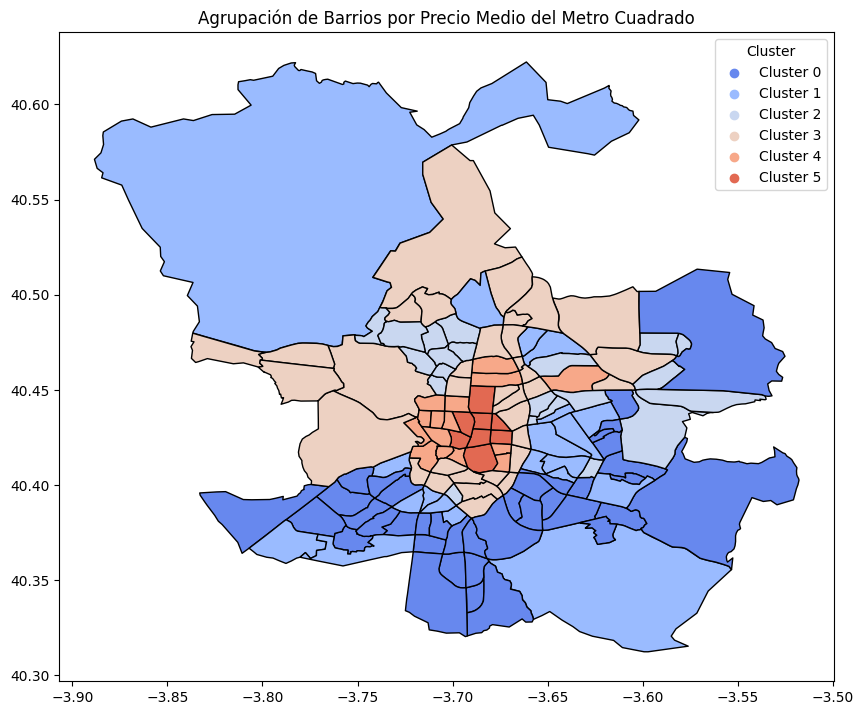

In [ ]:
# Definir una paleta de colores
palette = sns.color_palette('coolwarm', k_optimo).as_hex()

# Asignar colores a cada cluster
gdf['color'] = gdf['Cluster_Ordenado'].apply(lambda x: palette[x])

# Plotear el mapa
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(color=gdf['color'], edgecolor='black', ax=ax)

# Añadir una leyenda
for cluster in range(k_optimo):
    ax.scatter([], [], c=palette[cluster], label=f'Cluster {cluster}')
ax.legend(title='Cluster')

plt.title('Agrupación de Barrios por Precio Medio del Metro Cuadrado')
plt.show()


In [ ]:
gdf.head()

,LOCATIONID,LOCATIONNAME,ZONELEVELID,WKT_geometry,mean_UNITPRICE,geometry,Cluster,Cluster_Ordenado,color
0,0-EU-ES-28-07-001-079-16-002,CONDE ORGAZ-PIOVERA,8,"MULTIPOLYGON (((-3.63014 40.44939, -3.62633 40...",4997.529056,"MULTIPOLYGON (((-3.63014 40.44939, -3.62633 40...",5,4,#f7a889
1,0-EU-ES-28-07-001-079-16-004,PINAR DEL REY,8,"MULTIPOLYGON (((-3.655102 40.46681, -3.654251 ...",2890.201338,"MULTIPOLYGON (((-3.6551 40.46681, -3.65425 40....",0,1,#9abbff
2,0-EU-ES-28-07-001-079-21-004,TIMÓN,8,"MULTIPOLYGON (((-3.581744 40.47973, -3.60157 4...",3131.335558,"MULTIPOLYGON (((-3.58174 40.47973, -3.60157 40...",4,2,#c9d7f0
3,0-EU-ES-28-07-001-079-01-001,PALACIO,8,"MULTIPOLYGON (((-3.72044 40.42028, -3.72097 40...",4841.978005,"MULTIPOLYGON (((-3.72044 40.42028, -3.72097 40...",5,4,#f7a889
4,0-EU-ES-28-07-001-079-01-003,HUERTAS-CORTES,8,"MULTIPOLYGON (((-3.696488 40.41881, -3.699685 ...",5353.127293,"MULTIPOLYGON (((-3.69649 40.41881, -3.69968 40...",5,4,#f7a889


**Seleccionamos las Columnas Relevantes de gdf**


In [ ]:
# Seleccionar columnas necesarias
clusters_info = gdf[['LOCATIONNAME', 'Cluster_Ordenado']]


In [ ]:
clusters_info

,LOCATIONNAME,Cluster_Ordenado
0,CONDE ORGAZ-PIOVERA,4
1,PINAR DEL REY,1
2,TIMÓN,2
3,PALACIO,4
4,HUERTAS-CORTES,4
...,...,...
130,FUENTELARREINA,2
131,PEÑAGRANDE,2
132,LOS CÁRMENES,0
133,CASA DE CAMPO,3


In [ ]:
# Convertir a mayúsculas y eliminar espacios al inicio y al final
df_Madrid['neighbourhood'] = df_Madrid['neighbourhood'].str.upper().str.strip()
gdf['LOCATIONNAME'] = gdf['LOCATIONNAME'].str.upper().str.strip()


**Realizamos la Fusión (Merge) de df_Madrid con gdf**

In [ ]:
# Fusionar df_Madrid con clusters_info
df_Madrid = df_Madrid.merge(clusters_info, how='left', left_on='neighbourhood', right_on='LOCATIONNAME')

# Opcional: Eliminar la columna 'LOCATIONNAME' si ya no es necesaria
df_Madrid.drop(columns=['LOCATIONNAME'], inplace=True)


In [ ]:
df_Madrid.head()

,ASSETID,PERIOD,PRICE,UNITPRICE,ADTYPOLOGYID,ADOPERATIONID,CONSTRUCTEDAREA,ROOMNUMBER,BATHNUMBER,HASTERRACE,HASLIFT,HASAIRCONDITIONING,AMENITYID,HASPARKINGSPACE,HASNORTHORIENTATION,HASSOUTHORIENTATION,HASEASTORIENTATION,HASWESTORIENTATION,HASBOXROOM,HASWARDROBE,HASSWIMMINGPOOL,HASDOORMAN,HASGARDEN,ISDUPLEX,ISSTUDIO,ISINTOPFLOOR,FLOORCLEAN,FLATLOCATIONID,CADCONSTRUCTIONYEAR,CADMAXBUILDINGFLOOR,CADDWELLINGCOUNT,CADASTRALQUALITYID,BUILTTYPEID_1,BUILTTYPEID_2,BUILTTYPEID_3,DISTANCE_TO_CITY_CENTER,DISTANCE_TO_METRO,DISTANCE_TO_STREET,LONGITUDE,LATITUDE,CITYNAME,ADTYPOLOGY,ADOPERATION,neighbourhood,metros_within_500m,DISTANCIA_LATITUD,DISTANCIA_LONGITUD,Cluster_Ordenado
0,A2624736749193113090,4,166000,1844.444444,HOME,SALE,90,2,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,1.0,1986,10,32,5.0,0,0,1,7.953755,0.402011,6.504196,-3.611866,40.431013,Madrid,HOME,SALE,HELLÍN,2,1.688116,6.719162,0
1,A8841356095019025740,3,133000,1727.272727,HOME,SALE,77,3,1,1,1,1,3,0,0,1,1,0,0,0,0,0,0,0,0,0,3.0,1.0,1960,4,80,7.0,0,0,1,7.443821,0.480740,5.961369,-3.618239,40.431754,Madrid,HOME,SALE,HELLÍN,1,1.605735,6.179863,0
2,A6716251930495709236,3,98000,1719.298246,HOME,SALE,57,2,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,1960,4,9,7.0,0,0,1,7.473113,0.287270,6.039694,-3.617411,40.430101,Madrid,HOME,SALE,HELLÍN,1,1.789566,6.249980,0
3,A1897858214850462442,4,125000,2016.129032,HOME,SALE,62,3,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0,1.0,1960,5,11,7.0,0,0,1,7.613618,0.153489,6.203659,-3.615529,40.429363,Madrid,HOME,SALE,HELLÍN,1,1.871596,6.409172,0
4,A602619672115044517,3,111000,1947.368421,HOME,SALE,57,2,1,0,0,1,3,0,0,0,0,0,0,1,0,0,0,0,0,0,2.0,1.0,1960,4,17,7.0,0,0,1,7.328904,0.507474,5.855577,-3.619509,40.431351,Madrid,HOME,SALE,HELLÍN,0,1.650567,6.072430,0


**Verificamos la Asignación de Clusters**

In [ ]:
# Verificar si hay pisos sin asignar a un cluster
pisos_sin_cluster = df_Madrid[df_Madrid['Cluster_Ordenado'].isna()]
num_sin_cluster = pisos_sin_cluster.shape[0]

if num_sin_cluster > 0:
    print(f"Hay {num_sin_cluster} pisos sin asignar a un cluster:")
    print(pisos_sin_cluster[['neighbourhood']].drop_duplicates())
else:
    print("Todos los pisos han sido asignados a un cluster.")


Todos los pisos han sido asignados a un cluster.


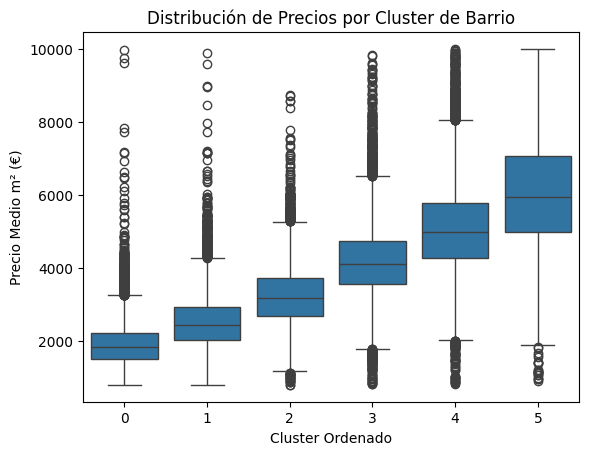

In [ ]:
sns.boxplot(data=df_Madrid, x='Cluster_Ordenado', y='UNITPRICE')

plt.title('Distribución de Precios por Cluster de Barrio')
plt.xlabel('Cluster Ordenado')
plt.ylabel('Precio Medio m² (€)')
plt.show()


## ML Models

**Cambiamos el precio por su logaritmo neperiano, para tener una distrubución más normal**

In [ ]:
#df_Madrid['PRICE'] = df_Madrid['PRICE'].apply(lambda x: np.log(x) if x > 0 else 0)

In [ ]:
df_Madrid.columns

Index(['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'ADTYPOLOGYID',
       'ADOPERATIONID', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
       'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'AMENITYID',
       'HASPARKINGSPACE', 'HASNORTHORIENTATION', 'HASSOUTHORIENTATION',
       'HASEASTORIENTATION', 'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE',
       'HASSWIMMINGPOOL', 'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO',
       'ISINTOPFLOOR', 'FLOORCLEAN', 'FLATLOCATIONID', 'CADCONSTRUCTIONYEAR',
       'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT', 'CADASTRALQUALITYID',
       'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_STREET',
       'LONGITUDE', 'LATITUDE', 'CITYNAME', 'ADTYPOLOGY', 'ADOPERATION',
       'neighbourhood', 'metros_within_500m', 'DISTANCIA_LATITUD',
       'DISTANCIA_LONGITUD', 'Cluster_Ordenado'],
      dtype='object')

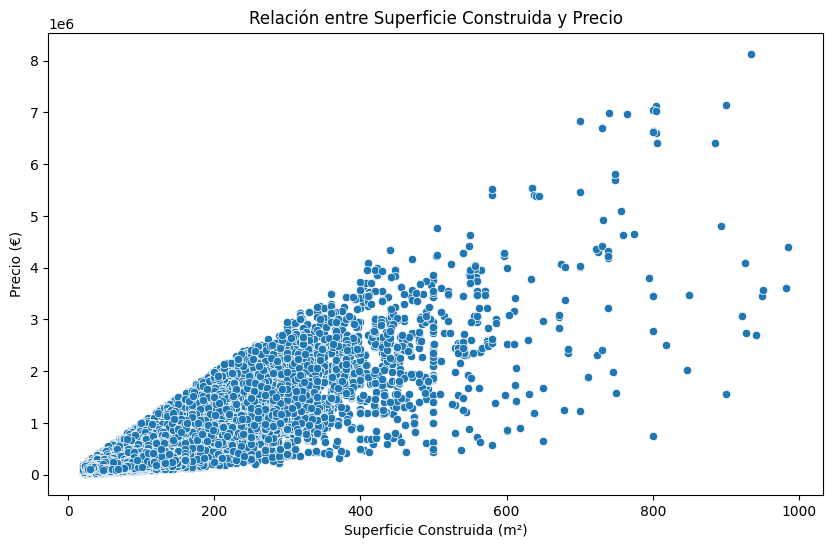

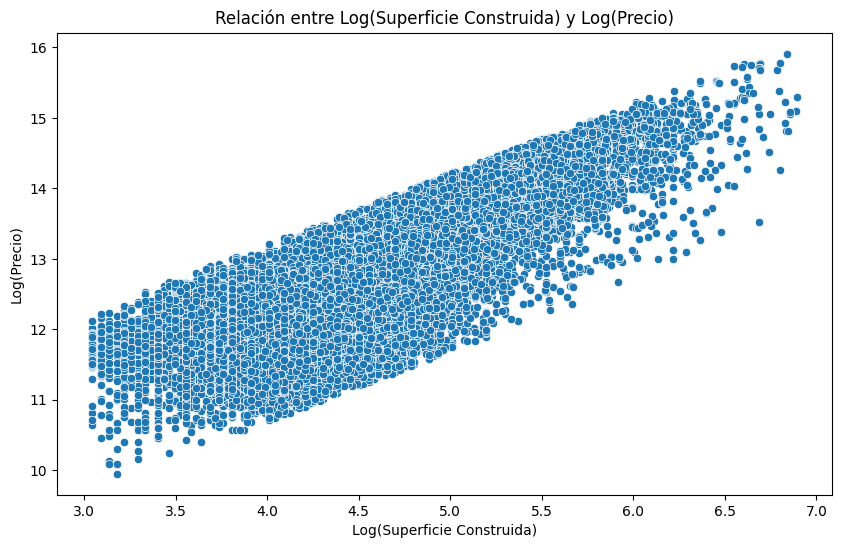

In [ ]:
# Relación original
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_Madrid, x='CONSTRUCTEDAREA', y='PRICE')
plt.title('Relación entre Superficie Construida y Precio')
plt.xlabel('Superficie Construida (m²)')
plt.ylabel('Precio (€)')
plt.show()

# Relación logarítmica
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_Madrid, x=np.log(df_Madrid['CONSTRUCTEDAREA']), y=np.log(df_Madrid['PRICE']))
plt.title('Relación entre Log(Superficie Construida) y Log(Precio)')
plt.xlabel('Log(Superficie Construida)')
plt.ylabel('Log(Precio)')
plt.show()


In [ ]:
df_Madrid_abridged = df_Madrid[df_Madrid['PERIOD']==4]
df_Madrid_abridged['Log_Superficie'] = np.log(df_Madrid_abridged['CONSTRUCTEDAREA'])

<ipython-input-112-335564b13e5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Madrid_abridged['Log_Superficie'] = np.log(df_Madrid_abridged['CONSTRUCTEDAREA'])


In [ ]:
df_Madrid_abridged.columns

Index(['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'ADTYPOLOGYID',
       'ADOPERATIONID', 'CONSTRUCTEDAREA', 'ROOMNUMBER', 'BATHNUMBER',
       'HASTERRACE', 'HASLIFT', 'HASAIRCONDITIONING', 'AMENITYID',
       'HASPARKINGSPACE', 'HASNORTHORIENTATION', 'HASSOUTHORIENTATION',
       'HASEASTORIENTATION', 'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE',
       'HASSWIMMINGPOOL', 'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO',
       'ISINTOPFLOOR', 'FLOORCLEAN', 'FLATLOCATIONID', 'CADCONSTRUCTIONYEAR',
       'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT', 'CADASTRALQUALITYID',
       'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_STREET',
       'LONGITUDE', 'LATITUDE', 'CITYNAME', 'ADTYPOLOGY', 'ADOPERATION',
       'neighbourhood', 'metros_within_500m', 'DISTANCIA_LATITUD',
       'DISTANCIA_LONGITUD', 'Cluster_Ordenado', 'Log_Superficie'],
      dtype='object')

In [ ]:
columns_to_keep = [
    'PRICE', 'Log_Superficie', 'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE',
    'HASLIFT', 'HASAIRCONDITIONING', 'HASSWIMMINGPOOL', 'ISSTUDIO',
    'ISINTOPFLOOR', 'HASPARKINGSPACE', 'HASGARDEN','CADCONSTRUCTIONYEAR',
    'DISTANCE_TO_METRO','DISTANCE_TO_STREET','metros_within_500m','Cluster_Ordenado'
]


df_Madrid_abridged = df_Madrid_abridged[columns_to_keep]



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
import statsmodels.api as sm

X = df_Madrid_abridged.drop(['PRICE'], axis=1)
y = np.log(df_Madrid_abridged['PRICE'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model_sm = sm.OLS(y_train, X_train_sm).fit()

y_pred = model_sm.predict(X_test_sm)

mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

print(model_sm.summary())

MAE: 0.17498289692914387
MDAE: 0.13674662659265202
RMSE: 0.23236582539005773
MAPE: 1.3975442769470576%
                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                 1.557e+04
Date:                Sun, 27 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:06:03   Log-Likelihood:                 1335.9
No. Observations:               25115   AIC:                            -2638.
Df Residuals:                   25098   BIC:                            -2500.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Supongamos que df_Madrid es tu DataFrame de pisos
# y que ya has realizado la asignación de clusters y otras características

# 1. Definir características (X) y objetivo (y)
X = df_Madrid_abridged.drop(['PRICE'], axis=1)  # Ajusta según tus columnas
y = np.log(df_Madrid_abridged['PRICE'])  # Aplicar logaritmo natural

# 2. Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Entrenar el modelo
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# 4. Realizar predicciones en el conjunto de prueba
y_pred_log = modelo.predict(X_test)

# 5. Calcular RMSE en la escala logarítmica
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
print(f'RMSE en log(precio): {rmse_log}')


RMSE en log(precio): 0.23236582539006173


In [ ]:
# Convertir predicciones logarítmicas a precios originales
y_pred = np.exp(y_pred_log)

# Convertir valores reales logarítmicos a precios originales
y_true = np.exp(y_test)


In [ ]:
# Calcular RMSE en la escala original
rmse_original = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE en precio original: {rmse_original}')


RMSE en precio original: 154494.8708830541


In [ ]:
from sklearn.metrics import mean_absolute_error

# Calcular MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE en precio original: {mae}')

# Calcular MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE en precio original: {mape}%')


MAE en precio original: 73744.50990518996
MAPE en precio original: 18.33045772439719%


In [ ]:
from sklearn.model_selection import cross_val_score

# Calcular RMSE con validación cruzada
scores = cross_val_score(modelo, X, y, scoring='neg_mean_squared_error', cv=5)
rmse_cv = np.sqrt(-scores.mean())
print(f'RMSE CV en log(precio): {rmse_cv}')


RMSE CV en log(precio): 0.2317503613274787


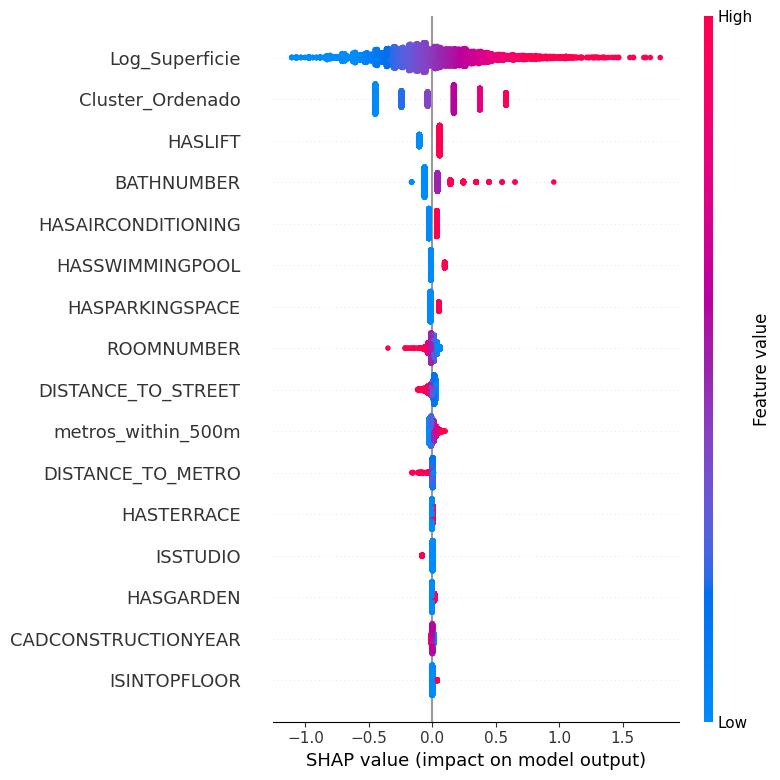

In [ ]:
import shap

# Crear un objeto explainer
explainer = shap.Explainer(modelo, X_train)
shap_values = explainer(X_test)

# Visualizar los valores SHAP
shap.summary_plot(shap_values, X_test)


*Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}*

Fitting 5 folds for each of 1 candidates, totalling 5 fits
MAE: 0.14444562874066014
MDAE: 0.10358585942424448
RMSE: 0.2047934092678557
MAPE: 1.1560606875204664%
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
                Feature  Importance
0        Log_Superficie    0.668474
15     Cluster_Ordenado    0.214294
13   DISTANCE_TO_STREET    0.023897
4               HASLIFT    0.022622
12    DISTANCE_TO_METRO    0.019452
11  CADCONSTRUCTIONYEAR    0.016108
2            BATHNUMBER    0.010915
1            ROOMNUMBER    0.005617
14   metros_within_500m    0.003909
5    HASAIRCONDITIONING    0.003824
6       HASSWIMMINGPOOL    0.003702
9       HASPARKINGSPACE    0.002768
3            HASTERRACE    0.002011
10            HASGARDEN    0.001326
8          ISINTOPFLOOR    0.000647
7              ISSTUDIO    0.000434


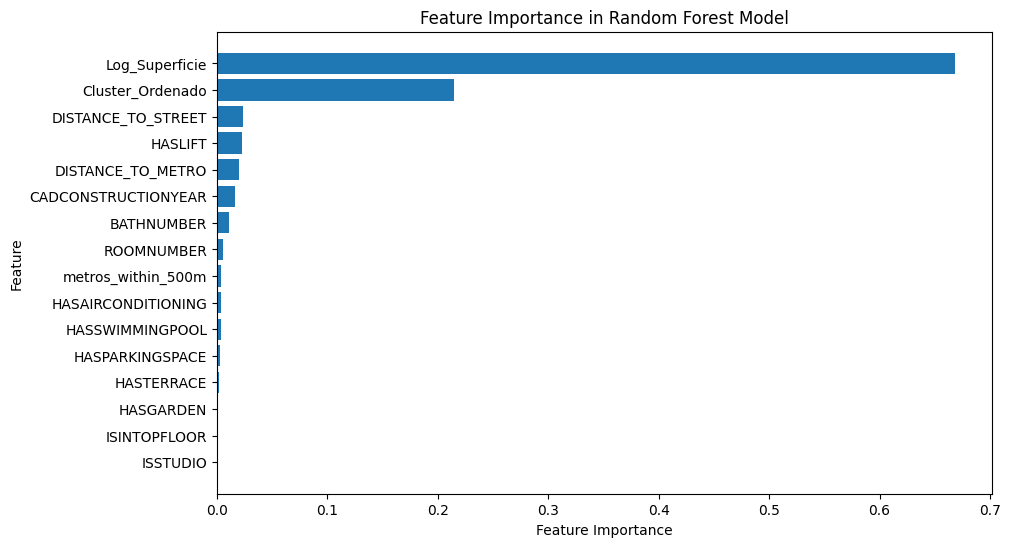

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
#import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [300], #[100, 200, 300]
    'max_depth': [None], #[10, 20, None]
    'min_samples_split': [2], #[2, 5, 10]
    'min_samples_leaf': [1], #[1, 2, 4]
    'bootstrap': [True] #[True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred_log = best_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_log)
mdae = median_absolute_error(y_test, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))
mape = np.mean(np.abs((y_test - y_pred_log) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

print(f'Best parameters found: {grid_search.best_params_}')

feature_importances = best_rf.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Convertir predicciones logarítmicas a precios originales
y_pred = np.exp(y_pred_log)

# Convertir valores reales logarítmicos a precios originales
y_true = np.exp(y_test)

# Calcular RMSE en la escala original
rmse_original = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE en precio original: {rmse_original}')



RMSE en precio original: 114970.60747677916


In [ ]:
# Calcular MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE en precio original: {mae}')

# Calcular MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE en precio original: {mape}%')

MAE en precio original: 58272.48349981926
MAPE en precio original: 15.12677647407458%


*Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 1.0}*


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [300], #[100, 200, 300],
    'max_depth': [10],#[3, 5, 7, 10],
    'learning_rate': [0.05], #[0.01, 0.05, 0.1, 0.2],
    'subsample': [1], #[0.6, 0.8, 1.0],
    'colsample_bytree':[0.6], #[0.6, 0.8, 1.0],
    'reg_alpha': [0.1], #[0, 0.1, 0.5, 1],
    'reg_lambda': [0] #[0, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

y_pred_log = best_xgb.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_log)
mdae = median_absolute_error(y_test, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))
mape = np.mean(np.abs((y_test - y_pred_log) / y_test)) * 100

print(f'MAE: {mae}')
print(f'MDAE: {mdae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

#Convertir predicciones logarítmicas a precios originales
y_pred = np.exp(y_pred_log)

# Convertir valores reales logarítmicos a precios originales
y_true = np.exp(y_test)

# Calcular RMSE en la escala original
rmse_original = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE en precio original: {rmse_original}')

# Calcular MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE en precio original: {mae}')

# Calcular MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE en precio original: {mape}%')

print(f'Best parameters found: {grid_search.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
MAE: 0.14361863190507906
MDAE: 0.10499164518857107
RMSE: 0.20113303446792163
MAPE: 1.1477605458469173%
RMSE en precio original: 131471.0807744398
MAE en precio original: 60100.64748815496
MAPE en precio original: 15.011049528989897%
Best parameters found: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 0, 'subsample': 1}


In [ ]:
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)


Lasso(alpha=0.1)